<a href="https://colab.research.google.com/github/mahsaghaderan99/DigikalaCommentAnalysis/blob/cnn/comment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation

In [1]:
!pip install stanza -U

Requirement already up-to-date: stanza in /usr/local/lib/python3.6/dist-packages (1.1.1)


#Imports

In [150]:
import stanza
import numpy as np
import pandas as pd 
import string
import cv2
import matplotlib.pyplot as plt
import seaborn as sn

In [151]:
import gensim 
from gensim.models import Word2Vec 

In [152]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time

#Configs

In [200]:
vectsize = 150
wordnum = 10
partofdb = 1
samplenum = 60035

In [154]:
stopwords = ['از','به','با','را','در','برای',
             'که','ازاینرو','این','ان','آن','ها',
             'آنجا','اینجا','ازجمله','ازروی','ازلحاظ','اش',
             'ات','ام','اید','تان','شان','مان',
             'الان','اند','انکه','او','ایم','اینطور',
             'انطور','اگر','اگرچه','رو','ب','اگه',
             'بلکه','تا','مثل','مثلا','مانند','ما',
             'من','ک','فلذا','لذا','فلان','های',
             'هایی','چه','هم','اما','چون','تو','توی','و',
             'البته','یه','یک','یا','هر','اینکه','ای','شما',
             '1','2','3','4','5','6','دو','اون']

#Data preparation

In [ ]:
#Save text file into drive

# !ls /content/drive/MyDrive
# !mkdir /content/drive/MyDrive/digikala
# !cp /content/digikala_dataset.txt /content/drive/MyDrive/digikala

In [ ]:
x = []
y = []
with open('/content/drive/MyDrive/digikala/digikala_dataset.txt','r') as f:
  for line in f:
    index = line.find('\t')
    dy = line[:index]
    dx = line[index+1:]
    x.append(dx)
    y.append(dy)


In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
punkts = {
    '!':' ',
    ')':' ',
    '(':' ',
    "'":' ',
    '.':' ',
    ':':' ',
    '-':' ',
    ',':' ',
    '*':' ',
    '/':' ',
    '[':' ',
    ']':' ',
    '?':' ',
    '؟':' ',
    '!':' ',
    '}':' ',
    '{':' ',
    '@':' '
}

In [ ]:
punct = str.maketrans(punkts)
nopunct_x = [s.translate(punct) for s in x]
nopunct_x = [s.replace('\n',' ').replace('\t',' ') for s in nopunct_x]

In [ ]:
data = {'label':y, 
        'comment':nopunct_x} 
df = pd.DataFrame(data) 
df 

,label,comment
0,0,لطفا رنگ سفید رو هم موجود کنید
1,0,با سلام؛ من همین الان میخواستم نوک مدادی بخرم ...
2,0,من یه روز گذاشتم شارژ 12 روز شارژ داشت
3,0,برای خاموش کردن نوار چراغ پایین گوشی از برنامه...
4,0,سلام بر دیجی کالا من میخواستم امروز بخرم ولی ا...
...,...,...
200756,0,لطفا موجود کنین
200757,-1,من 1 ساله دارمش واقعا بده هنگ زیاد داغ شدن زی...
200758,0,اگه دو سیمشم بیاری دیجی کالا و نقد و بررسی هم ...
200759,1,سلام من این گوشیو 2هفته پیش خریدم البته ایم بگ...


In [ ]:
#create csv file
# !touch /content/drive/MyDrive/digikala/digikala.csv

In [ ]:
df.to_csv ('/content/drive/MyDrive/digikala/digikala.csv', index = False, header=True)

#Tokenize

###LOad Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/digikala/digikala.csv')

In [155]:
label = np.array(df['label'])
clean_com = np.array(df['comment'])

In [6]:
stanza.download('fa') 

2021-01-08 11:04:06 INFO: Downloading default packages for language: fa (Persian)...
2021-01-08 11:04:06 INFO: File exists: /root/stanza_resources/fa/default.zip.
2021-01-08 11:04:09 INFO: Finished downloading models and saved to /root/stanza_resources.


In [197]:
# clean_com, label = shuffle(clean_com, label, random_state=0)
neg = np.argwhere(label == -1)
pos = np.argwhere(label == 1)
zero = np.argwhere(label == 0)
np.random.shuffle(zero)
zero = zero[:10000]
zero = np.concatenate((zero,pos,neg)).flatten()
np.random.shuffle(zero)

In [198]:
partedx = clean_com[zero]
partedy = label[zero]

In [199]:
len(partedy)

60035

###model1
tokenizee + skip grams

In [201]:
nlp = stanza.Pipeline(processors='tokenize', lang='fa', tokenize_pretokenized=True, use_gpu=True)
tokens = []
for row in partedx:
  doc = nlp(row)
  try:
    sentence = list(doc.sentences)[0]
    tokenz = np.array([token.text for token in sentence.tokens])
  except:
    print(doc.sentences)
    tokenz=[]
  tokens.append(tokenz)
  

2021-01-08 12:21:16 INFO: Loading these models for language: fa (Persian):
| Processor | Package |
-----------------------
| tokenize  | seraji  |

2021-01-08 12:21:16 INFO: Use device: gpu
2021-01-08 12:21:16 INFO: Loading: tokenize
2021-01-08 12:21:16 INFO: Done loading processors!


In [202]:
nptokens = np.array(tokens) 
nostopwords = [[token for token in token_row if token not in stopwords] for token_row in nptokens]
nostopwords = np.array(nostopwords)
model1 = gensim.models.Word2Vec(nostopwords, min_count = 5, size = vectsize, window = 5,sg=0) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


###model2

lemmatizer + CBOW

This part use half of data due its long run time!

In [ ]:
nlplemm = stanza.Pipeline(processors='tokenize,lemma', lang='fa',use_gpu=True)
lemmas = []
i =0
for row in partedx:
  if i%1000 == 0: print(i)
  i +=1
  try:
    sentence = list(nlplemm(row).sentences)[0]
    lemmas.append([word.lemma for word in sentence.words if word.lemma != None])
  except:
    print(doc.sentences)
    continue

In [ ]:
nplemmas = np.array(lemmas) 
nostopwords = [[token for token in token_row if token not in stopwords] for token_row in nplemmas]
nostopwords = np.array(nostopwords)
model2 = gensim.models.Word2Vec(nostopwords, min_count = 3, size = vectsize, window = 5,sg=0) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


###choose model

In [203]:
model = model1

##Similar words

In [ ]:
result = model.most_similar_cosmul(positive=['خوب', 'ممنون'], negative=['متوسط'])
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('ممنونم', 1.0470558404922485),
 ('مرسی', 1.0181233882904053),
 ('متشکرم', 0.9466909170150757),
 ('ممنو', 0.9180619716644287),
 ('ممنوم', 0.9062881469726562),
 ('خوشحال', 0.8804005980491638),
 ('متشکر', 0.8733648657798767),
 ('تشکر', 0.847612738609314),
 ('باتشکر', 0.8362003564834595),
 ('ممنونش', 0.8347392082214355)]

In [ ]:
result = model.most_similar_cosmul(positive=['متوسط', 'معمولی'], negative=['قبول'])
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('ترکیبی', 1.5447357892990112),
 ('ممتد', 1.5133628845214844),
 ('مداوم', 1.4331914186477661),
 ('نرمال', 1.3832614421844482),
 ('روزانه', 1.3396459817886353),
 ('روزمره', 1.2819952964782715),
 ('معمول', 1.2774665355682373),
 ('نکشی', 1.2387685775756836),
 ('سهولت', 1.2210999727249146),
 ('عادی', 1.2001959085464478)]

In [ ]:
result = model.most_similar_cosmul(positive=['موبایل', 'گوشی'], negative=['کامپیوتر'])
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('گوشیهای', 1.1535037755966187),
 ('گوشیه', 1.1011139154434204),
 ('فبلت', 1.0674474239349365),
 ('گوشیو', 0.978054940700531),
 ('گوشیها', 0.953982412815094),
 ('گوشیای', 0.9519391655921936),
 ('پرچمداران', 0.9375668168067932),
 ('تبلت', 0.9226328134536743),
 ('s6', 0.9191224575042725),
 ('گوشیهایی', 0.916860044002533)]

In [ ]:
result = model.most_similar_cosmul(positive=['سامسونگ', 'گوشی'], negative=['هواوی'])
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('دستگاه', 0.8933578133583069),
 ('آیفون', 0.8378643989562988),
 ('تبلت', 0.8332229852676392),
 ('فبلت', 0.8310238718986511),
 ('گوشیه', 0.823602557182312),
 ('قلم', 0.8118154406547546),
 ('گوشیهای', 0.8037421703338623),
 ('خمیده', 0.7968593835830688),
 ('گجت', 0.7861220240592957),
 ('ایفون', 0.7834344506263733)]

!pip uninstall torch
!pip install torch


##Test word2vec Model

In [ ]:
model.similarity('بد', 'عالی')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.381894

In [ ]:
model.similarity('بو', 'طعم')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.41394544

In [ ]:
model.similarity('سفید', 'عالی')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.03201149

In [ ]:
model.similarity('بد', 'خش')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.2002462

In [ ]:
model.similarity('بد', 'تیره')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.1302752

In [ ]:
model.similarity('دار', 'دوست')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.16194682

In [ ]:
model.similarity('ندار', 'دوست')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.051829193

In [ ]:
model.similarity('عالی', 'مرسی')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.16090499

In [ ]:
model.similarity('مرسی', 'ممنون')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.7638013

In [ ]:
model.similarity('تشکر', 'ممنون')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.6739584

In [ ]:
model.similarity('افتضاح', 'ممنون')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.10391396

In [ ]:
model.similarity('مرسی', 'افتضاح')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.20407669

In [ ]:
model.similarity('توقع', 'سفید')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.12276377

In [ ]:
model.similarity('خوب', 'بد')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.58526194

In [ ]:
model.similarity('زیبا', 'قشنگ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.55045164

In [ ]:
model.similarity('داغ', 'گرم')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.7483523

##Similar by word

In [ ]:
 model.similar_by_word("گوشی")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('گوشیه', 0.664944052696228),
 ('تبلت', 0.5997394323348999),
 ('گوشیهای', 0.5865913033485413),
 ('فبلت', 0.5534288287162781),
 ('موبایل', 0.5393733978271484),
 ('دستگاه', 0.5358886122703552),
 ('گوشیو', 0.5237420797348022),
 ('کوشی', 0.4739921987056732),
 ('گوشیها', 0.4463856816291809),
 ('گوشیای', 0.4426014721393585)]

In [ ]:
 model.similar_by_word("لپتاپ")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('لب', 0.6161485314369202),
 ('لپ', 0.5653797388076782),
 ('لبتاب', 0.5559527277946472),
 ('تاب', 0.5490288734436035),
 ('ویندوزی', 0.5439936518669128),
 ('کامپیوتر', 0.5369860529899597),
 ('دسک', 0.5358223915100098),
 ('تاپ', 0.5322171449661255),
 ('لپتاب', 0.5055623650550842),
 ('سرفیس', 0.5036083459854126)]

##Similarity by sentence

In [ ]:
model.wmdistance('کتاب خیلی خوبیه', 'خواندن این کتاب را پیشنهاد میکنم')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  """Entry point for launching an IPython kernel.


6.252728066862505

In [ ]:
model.wmdistance('گوشی از علادین بخری بهتری', 'خرید این عطر رو توضیه میکنم')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  """Entry point for launching an IPython kernel.


2.4633872753901165

In [ ]:
model.wmdistance('به معنی واقعی گوشی ناکار آمدیه', 'خرید این موبایل رو توضیه میکنم')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  """Entry point for launching an IPython kernel.


2.6033762720705567

##Most repeted words

In [ ]:
model.wv.index2entity[:50]

['گوشی',
 'خیلی',
 'سلام',
 'ولی',
 'داره',
 'میشه',
 'هست',
 'می',
 'کنید',
 'دیجی',
 'صفحه',
 'فقط',
 'دوستان',
 'نظر',
 'همه',
 'نیست',
 'دیگه',
 'کیفیت',
 'دوربین',
 'واقعا',
 'کار',
 'دارم',
 'میکنه',
 'کردم',
 'لطفا',
 'بود',
 'کالا',
 'باید',
 'استفاده',
 'نداره',
 'عالیه',
 'سامسونگ',
 'است',
 'باشه',
 'شده',
 '،',
 'خریدم',
 'خوب',
 'کنم',
 'موجود',
 'قیمت',
 'بازی',
 'بعد',
 'مشکل',
 'عالی',
 'هیچ',
 'ی',
 'تبلت',
 'برنامه',
 'میکنم']

#Generate features

In [204]:
vects = []
emptyvect = np.ones(vectsize)* 0.01
for sent in nostopwords:
  vect = []
  if len(sent) >=wordnum:
    for word in sent[:wordnum]:
      try:
        vect.append(model.wv[word])
      except:
        vect.append(emptyvect)
  else:
    for word in sent:
      try:
        vect.append(model.wv[word])
      except:
        vect.append(emptyvect)
    for i in range(0,wordnum-len(sent)):
      vect.append(emptyvect)
  vects.append(np.array(vect))
  


In [205]:
normvects = vects - np.min(vects)
normvects = normvects/np.max(normvects)

In [206]:
X = np.array(vects)
X = np.expand_dims(X,3)
print('X shape is',X.shape)
Y = np.array(partedy)
print('Y shape is ',Y.shape)

X shape is (60035, 10, 150, 1)
Y shape is  (60035,)


In [207]:
X, Y = shuffle(X, Y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)

In [208]:
Y.shape

(60035,)

#CNN

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 10, 150, 1)]      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 8, 140, 8)         272       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 8, 132, 8)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 6, 123, 4)         964       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 6, 115, 4)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2760)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 64)                176

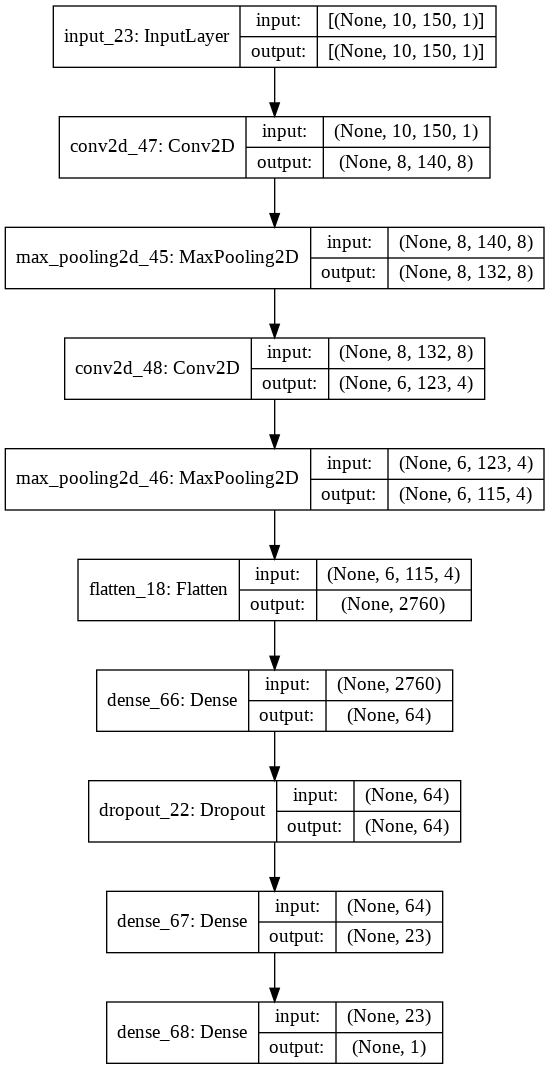

In [215]:
visible = Input(shape=(wordnum,vectsize,1))
conv1 = Conv2D(8, (3,11), activation='relu')(visible)
pool1 = MaxPooling2D((1,9), strides=(1,1))(conv1)
conv2 = Conv2D(4, (3,10), activation='relu')(pool1)
pool2 = MaxPooling2D((1,9), strides=(1,1))(conv2)
gavgpool = Flatten()(pool2)
dens1 = Dense(64, activation='relu')(gavgpool)
drop2 = Dropout(0.3)(dens1)
dens2 = Dense(23, activation='relu')(drop2)
dens4 = Dense(1, activation='tanh')(dens2)
model = Model(inputs=visible, outputs=dens4)

model.summary()
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [210]:
X_train.shape

(48028, 10, 150, 1)

In [211]:
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['accuracy'])
checkpoint = ModelCheckpoint('model.h5', verbose=1, monitor='val_accuracy',save_best_only=True,save_weights_only=True, mode='auto')  
with tf.device('/device:GPU:0'):
  start_time = time.time()
  history = model.fit(x=X_train,y = y_train,validation_split=0.2 ,epochs=50,batch_size =100,callbacks=[checkpoint])
  print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
385/385 [==============================] - 2s 5ms/step - loss: 0.4220 - accuracy: 0.7313 - val_loss: 0.3368 - val_accuracy: 0.7243

Epoch 00001: val_accuracy improved from -inf to 0.72434, saving model to model.h5
Epoch 2/50
385/385 [==============================] - 2s 4ms/step - loss: 0.3361 - accuracy: 0.7113 - val_loss: 0.3324 - val_accuracy: 0.7296

Epoch 00002: val_accuracy improved from 0.72434 to 0.72965, saving model to model.h5
Epoch 3/50
385/385 [==============================] - 2s 4ms/step - loss: 0.3255 - accuracy: 0.7283 - val_loss: 0.3249 - val_accuracy: 0.7477

Epoch 00003: val_accuracy improved from 0.72965 to 0.74766, saving model to model.h5
Epoch 4/50
385/385 [==============================] - 2s 4ms/step - loss: 0.3201 - accuracy: 0.7336 - val_loss: 0.3337 - val_accuracy: 0.7583

Epoch 00004: val_accuracy improved from 0.74766 to 0.75828, saving model to model.h5
Epoch 5/50
385/385 [==============================] - 2s 4ms/step - loss: 0.3138 - accuracy

In [214]:
predicted = model.evaluate(X_test,y_test)
print(predicted)
# print(y_test[:10])

376/376 [==============================] - 1s 2ms/step - loss: 0.3287 - accuracy: 0.7511
[0.32871147990226746, 0.7510618567466736]


In [213]:
np.argwhere(y_tested==2).shape

(9215, 1)